In [1]:
import copy
import json
import math
import os
import urllib.request
from urllib.error import HTTPError

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

%matplotlib inline
from IPython.display import set_matplotlib_formats
from matplotlib import cm
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm

set_matplotlib_formats("svg", "pdf")  # For export
sns.set()

In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/InitOptim/")

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


In [3]:

# Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2861,), (0.3530,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



We create a linear neural network

In [4]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Args:
            act_fn: Object of the activation function that should be used as non-linearity in the network.
            input_size: Size of the input images in pixels
            num_classes: Number of classes we want to predict
            hidden_sizes: A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        # A module list registers a list of modules as submodules (e.g. for parameters)
        self.layers = nn.ModuleList(layers)

        self.config = {
            "act_fn": act_fn.__class__.__name__,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

For the activation functions, we make use of PyTorch's torch.nn library instead of implementing ourselves. However, we also define an Identity activation function. Although this activation function would significantly limit the network's modeling capabilities, we will use it in the first steps of our discussion about initialization (for simplicity).

In [5]:
class Identity(nn.Module):
    def forward(self, x):
        return x


act_fn_by_name = {"tanh": nn.Tanh, "relu": nn.ReLU, "identity": Identity}

Finally, we define a few plotting functions that we will use for our discussions. These functions help us to (1) visualize the weight/parameter distribution inside a network, (2) visualize the gradients that the parameters at different layers receive, and (3) the activations, i.e. the output of the linear layers. The detailed code is not important, but feel free to take a closer look if interested.

In [6]:
##############################################################


def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index % columns]
        sns.histplot(
            val_dict[key],
            ax=key_ax,
            color=color,
            bins=50,
            stat=stat,
            kde=use_kde and ((val_dict[key].max() - val_dict[key].min()) > 1e-8),
        )  # Only plot kde if there is variance
        hidden_dim_str = (
            r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape) > 1 else ""
        )
        key_ax.set_title(f"{key} {hidden_dim_str}")
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig


##############################################################


def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    # Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()


##############################################################


def visualize_gradients(model, color="C0", print_variance=False):
    """
    Args:
        net: Object of class BaseNetwork
        color: Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels)  # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {
        name: params.grad.view(-1).cpu().clone().numpy()
        for name, params in model.named_parameters()
        if "weight" in name
    }
    model.zero_grad()

    # Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")


##############################################################


def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    # Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

## Initialization

Before starting our discussion about initialization, it should be noted that there exist many very good blog posts about the topic of neural network initialization (for example [deeplearning.ai](https://www.deeplearning.ai/ai-notes/initialization/), or a more [math-focused blog post](https://pouannes.github.io/blog/initialization)).
In case something remains unclear after this tutorial, we recommend skimming through these blog posts as well.

When initializing a neural network, there are a few properties we would like to have.
First, the variance of the input should be propagated through the model to the last layer, so that we have a similar standard deviation for the output neurons.
If the variance would vanish the deeper we go in our model, it becomes much harder to optimize the model as the input to the next layer is basically a single constant value.
Similarly, if the variance increases, it is likely to explode (i.e. head to infinity) the deeper we design our model.
The second property we look out for in initialization techniques is a gradient distribution with equal variance across layers.
If the first layer receives much smaller gradients than the last layer, we will have difficulties in choosing an appropriate learning rate.

As a starting point for finding a good method, we will analyze different initialization based on our linear neural network with no activation function (i.e. an identity).
We do this because initializations depend on the specific activation
function used in the network, and we can adjust the initialization
schemes later on for our specific choice.

In [7]:
model = BaseNetwork(act_fn=Identity()).to(device)

### Constant initialization

The first initialization we can consider is to initialize all weights with the same constant value.
Intuitively, setting all weights to zero is not a good idea as the propagated gradient will be zero.
However, what happens if we set all weights to a value slightly larger or smaller than 0?
To find out, we can implement a function for setting all parameters below and visualize the gradients.

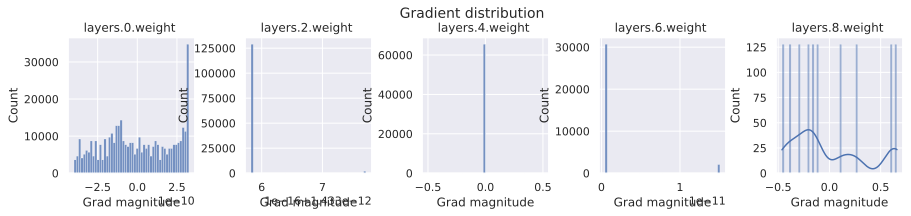

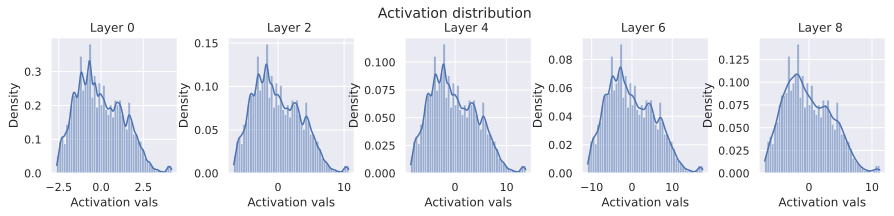

Layer 0 - Variance: 1.8647621870040894
Layer 2 - Variance: 12.220905303955078
Layer 4 - Variance: 20.022722244262695
Layer 6 - Variance: 32.80522537231445
Layer 8 - Variance: 13.437021255493164


In [8]:
def const_init(model, fill=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(fill)


const_init(model, fill=0.005)
visualize_gradients(model)
print()
visualize_activations(model, print_variance=True)

As we can see, only the first and the last layer have diverse gradient distributions while the other three layers have the same gradient for all weights (note that this value is unequal 0, but often very close to it). Having the same gradient for parameters that have been initialized with the same values means that we will always have the same value for those parameters. This would make our layer useless and reduce our effective number of parameters to 1. Thus, we cannot use a constant initialization to train our networks.

### Constant variance

From the experiment above, we have seen that a constant value is not working.
So instead, how about we initialize the parameters by randomly sampling from a distribution like a Gaussian?
The most intuitive way would be to choose one variance that is used for all layers in the network.
Let's implement it below, and visualize the activation distribution across layers.

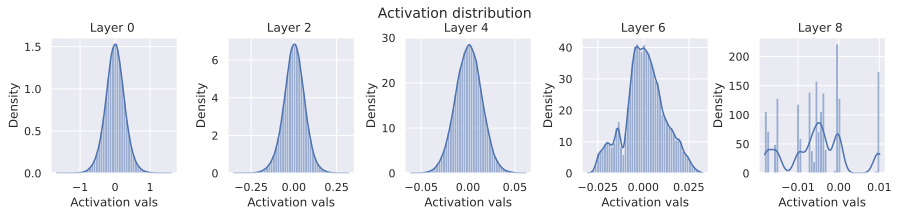

Layer 0 - Variance: 0.07824330031871796
Layer 2 - Variance: 0.0038693761453032494
Layer 4 - Variance: 0.00019961273937951773
Layer 6 - Variance: 0.00012268871068954468
Layer 8 - Variance: 5.5615208111703396e-05


In [9]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(mean=0.0, std=std)


var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

The variance of the activation becomes smaller and smaller across layers, and almost vanishes in the last layer.
Alternatively, we could use a higher standard deviation:

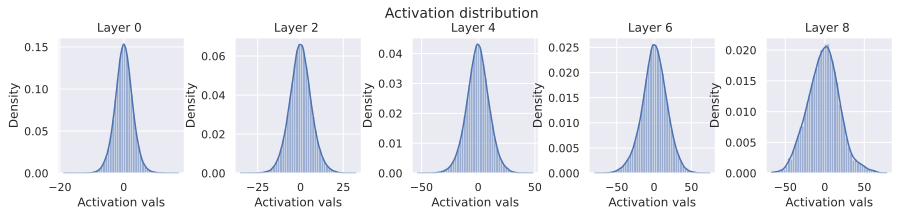

Layer 0 - Variance: 7.969846725463867
Layer 2 - Variance: 41.67656326293945
Layer 4 - Variance: 99.2983627319336
Layer 6 - Variance: 280.3054504394531
Layer 8 - Variance: 402.34405517578125


In [10]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

With a higher standard deviation, the activations are likely to explode.
You can play around with the specific standard deviation values, but it will be hard to find one that gives us a good activation distribution across layers and is very specific to our model.
If we would change the hidden sizes or number of layers, you would have
to search all over again, which is neither efficient nor recommended.

### How to find appropriate initialization values

From our experiments above, we have seen that we need to sample the weights from a distribution, but are not sure which one exactly.
As a next step, we will try to find the optimal initialization from the perspective of the activation distribution.
For this, we state two requirements:

1. The mean of the activations should be zero
2. The variance of the activations should stay the same across every layer

Suppose we want to design an initialization for the following layer: $y=Wx+b$ with $y\in\mathbb{R}^{d_y}$, $x\in\mathbb{R}^{d_x}$.
Our goal is that the variance of each element of $y$ is the same as the input, i.e. $\text{Var}(y_i)=\text{Var}(x_i)=\sigma_x^{2}$, and that the mean is zero.
We assume $x$ to also have a mean of zero, because, in deep neural networks, $y$ would be the input of another layer.
This requires the bias and weight to have an expectation of 0.
Actually, as $b$ is a single element per output neuron and is constant across different inputs, we set it to 0 overall.

Next, we need to calculate the variance with which we need to initialize the weight parameters.
Along the calculation, we will need to following variance rule: given two independent variables, the variance of their product is $\text{Var}(X\cdot Y) = \mathbb{E}(Y)^2\text{Var}(X) + \mathbb{E}(X)^2\text{Var}(Y) + \text{Var}(X)\text{Var}(Y) = \mathbb{E}(Y^2)\mathbb{E}(X^2)-\mathbb{E}(Y)^2\mathbb{E}(X)^2$ ($X$ and $Y$ are not refering to $x$ and $y$, but any random variable).

The needed variance of the weights, $\text{Var}(w_{ij})$, is calculated as follows:

$$
\begin{split}
    y_i & = \sum_{j} w_{ij}x_{j}\hspace{10mm}\text{Calculation of a single output neuron without bias}\\
    \text{Var}(y_i) = \sigma_x^{2} & = \text{Var}\left(\sum_{j} w_{ij}x_{j}\right)\\
    & = \sum_{j} \text{Var}(w_{ij}x_{j}) \hspace{10mm}\text{Inputs and weights are independent of each other}\\
    & = \sum_{j} \text{Var}(w_{ij})\cdot\text{Var}(x_{j}) \hspace{10mm}\text{Variance rule (see above) with expectations being zero}\\
    & = d_x \cdot \text{Var}(w_{ij})\cdot\text{Var}(x_{j}) \hspace{10mm}\text{Variance equal for all $d_x$ elements}\\
    & = \sigma_x^{2} \cdot d_x \cdot \text{Var}(w_{ij})\\
    \Rightarrow \text{Var}(w_{ij}) = \sigma_{W}^2 & = \frac{1}{d_x}\\
\end{split}
$$

Thus, we should initialize the weight distribution with a variance of the inverse of the input dimension $d_x$.
Let's implement it below and check whether this holds:

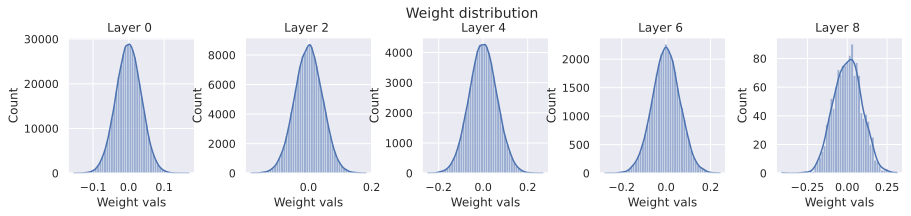

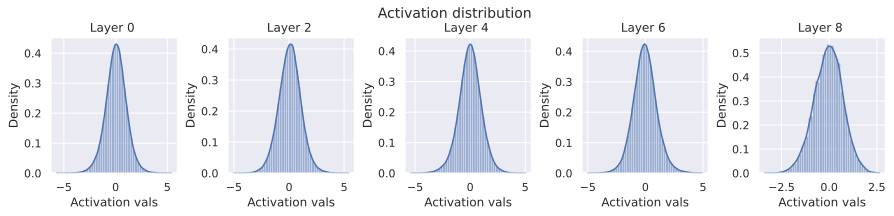

Layer 0 - Variance: 1.0119162797927856
Layer 2 - Variance: 1.0187604427337646
Layer 4 - Variance: 1.052771806716919
Layer 6 - Variance: 1.044123888015747
Layer 8 - Variance: 0.5695388913154602


In [11]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0 / math.sqrt(param.shape[1]))


equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

As we expected, the variance stays indeed constant across layers.
Note that our initialization does not restrict us to a normal distribution, but allows any other distribution with a mean of 0 and variance of $1/d_x$.
You often see that a uniform distribution is used for initialization.
A small benefit of using a uniform instead of a normal distribution is that we can exclude the chance of initializing very large or small weights.

Besides the variance of the activations, another variance we would like to stabilize is the one of the gradients.
This ensures a stable optimization for deep networks.
It turns out that we can do the same calculation as above starting from $\Delta x=W\Delta y$, and come to the conclusion that we should initialize our layers with $1/d_y$ where $d_y$ is the number of output neurons.
You can do the calculation as a practice, or check a thorough explanation in [this blog post](https://pouannes.github.io/blog/initialization).
As a compromise between both constraints, [Glorot and Bengio (2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?hc_location=ufi) proposed to use the harmonic mean of both values.
This leads us to the well-known Xavier initialization:

$$W\sim \mathcal{N}\left(0,\frac{2}{d_x+d_y}\right)$$

If we use a uniform distribution, we would initialize the weights with:

$$W\sim U\left[-\frac{\sqrt{6}}{\sqrt{d_x+d_y}}, \frac{\sqrt{6}}{\sqrt{d_x+d_y}}\right]$$

Let's shortly implement it and validate its effectiveness:

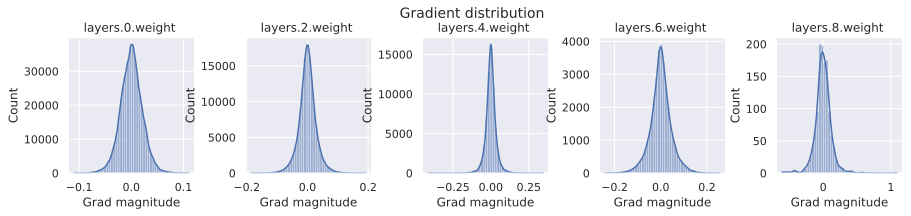

layers.0.weight - Variance: 0.0004423784848768264
layers.2.weight - Variance: 0.0008295236038975418
layers.4.weight - Variance: 0.0011885120766237378
layers.6.weight - Variance: 0.0020610070787370205
layers.8.weight - Variance: 0.015271211043000221


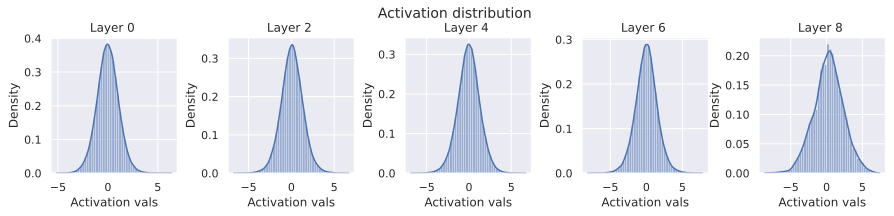

Layer 0 - Variance: 1.1825087070465088
Layer 2 - Variance: 1.6406207084655762
Layer 4 - Variance: 1.703526258468628
Layer 6 - Variance: 2.2365705966949463
Layer 8 - Variance: 4.283400535583496


In [12]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6) / math.sqrt(param.shape[0] + param.shape[1])
            param.data.uniform_(-bound, bound)


xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

We see that the Xavier initialization balances the variance of gradients and activations.
Note that the significantly higher variance for the output layer is due to the large difference of input and output dimension ($128$ vs $10$).
However, we currently assumed the activation function to be linear.
So what happens if we add a non-linearity?
In a tanh-based network, a common assumption is that for small values during the initial steps in training, the $\tanh$ works as a linear function such that we don't have to adjust our calculation.
We can check if that is the case for us as well:

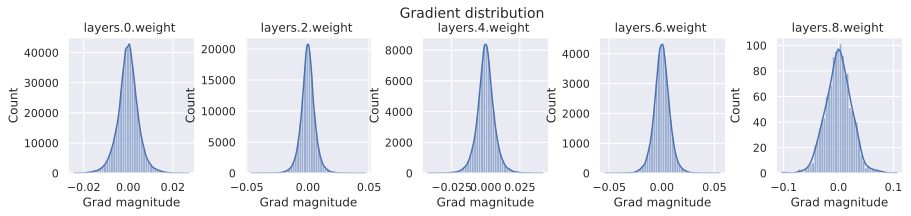

layers.0.weight - Variance: 2.187840436818078e-05
layers.2.weight - Variance: 3.3489610359538347e-05
layers.4.weight - Variance: 4.1277497075498104e-05
layers.6.weight - Variance: 5.691138721886091e-05
layers.8.weight - Variance: 0.0005541694117709994


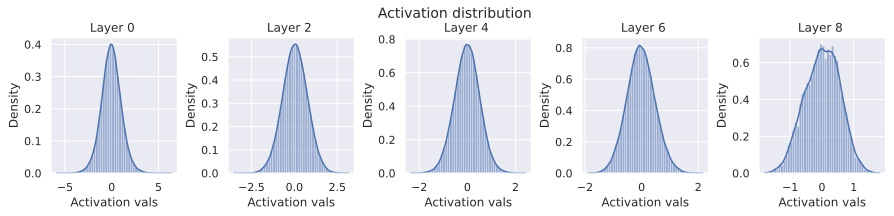

Layer 0 - Variance: 1.1356968879699707
Layer 2 - Variance: 0.5214540958404541
Layer 4 - Variance: 0.2764779031276703
Layer 6 - Variance: 0.24597960710525513
Layer 8 - Variance: 0.30001071095466614


In [13]:
model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

Although the variance decreases over depth, it is apparent that the activation distribution becomes more focused on the low values.
Therefore, our variance will stabilize around 0.25 if we would go even deeper.
Hence, we can conclude that the Xavier initialization works well for Tanh networks.
But what about ReLU networks?
Here, we cannot take the previous assumption of the non-linearity becoming linear for small values.
The ReLU activation function sets (in expectation) half of the inputs to 0 so that also the expectation of the input is not zero.
However, as long as the expectation of $W$ is zero and $b=0$, the expectation of the output is zero.
The part where the calculation of the ReLU initialization differs from the identity is when determining $\text{Var}(w_{ij}x_{j})$:

$$\text{Var}(w_{ij}x_{j})=\underbrace{\mathbb{E}[w_{ij}^2]}_{=\text{Var}(w_{ij})}\mathbb{E}[x_{j}^2]-\underbrace{\mathbb{E}[w_{ij}]^2}_{=0}\mathbb{E}[x_{j}]^2=\text{Var}(w_{ij})\mathbb{E}[x_{j}^2]$$

If we assume now that $x$ is the output of a ReLU activation (from a previous layer, $x=max(0,\tilde{y})$), we can calculate the expectation as follows:


$$
\begin{split}
    \mathbb{E}[x^2] & =\mathbb{E}[\max(0,\tilde{y})^2]\\
                    & =\frac{1}{2}\mathbb{E}[{\tilde{y}}^2]\hspace{2cm}\tilde{y}\text{ is zero-centered and symmetric}\\
                    & =\frac{1}{2}\text{Var}(\tilde{y})
\end{split}$$

Thus, we see that we have an additional factor of 1/2 in the equation, so that our desired weight variance becomes $2/d_x$.
This gives us the Kaiming initialization (see [He, K. et al.
(2015)](https://arxiv.org/pdf/1502.01852.pdf)).
Note that the Kaiming initialization does not use the harmonic mean between input and output size.
In their paper (Section 2.2, Backward Propagation, last paragraph), they argue that using $d_x$ or $d_y$ both lead to stable gradients throughout the network, and only depend on the overall input and output size of the network.
Hence, we can use here only the input $d_x$:

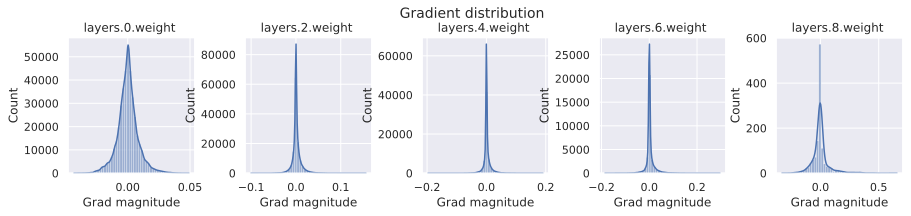

layers.0.weight - Variance: 6.90413944539614e-05
layers.2.weight - Variance: 0.00010353385732742026
layers.4.weight - Variance: 0.0001678684784565121
layers.6.weight - Variance: 0.00038313522236421704
layers.8.weight - Variance: 0.0057595157995820045


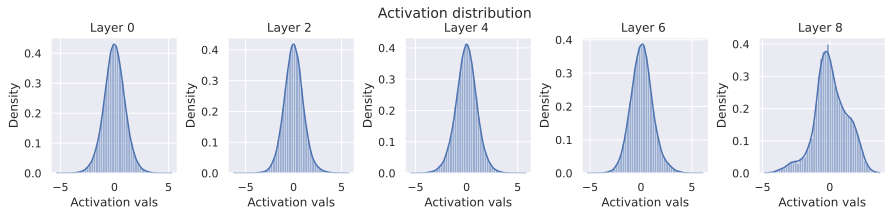

Layer 0 - Variance: 0.9718969464302063
Layer 2 - Variance: 1.041566014289856
Layer 4 - Variance: 1.1054439544677734
Layer 6 - Variance: 1.2034541368484497
Layer 8 - Variance: 1.5661451816558838


In [14]:
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"):  # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1 / math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2) / math.sqrt(param.shape[1]))


model = BaseNetwork(act_fn=nn.ReLU()).to(device)
kaiming_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

The variance stays stable across layers.
We can conclude that the Kaiming initialization indeed works well for ReLU-based networks.
Note that for Leaky-ReLU etc., we have to slightly adjust the factor of $2$ in the variance as half of the values are not set to zero anymore.
PyTorch provides a function to calculate this factor for many activation
function, see `torch.nn.init.calculate_gain`
([link](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain)).

In [15]:
gain = nn.init.calculate_gain('leaky_relu', 0.2)
gain